<a href="https://colab.research.google.com/github/ArtemChemist/CFU_counter/blob/main/EffNetB5_manual_aug_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 68.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting unins

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
from datetime import datetime
import time
import csv

import cv2

from keras.models import Model, Sequential
from keras import layers
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
import tensorflow as tf
print(tf.__version__)

from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop

from tensorflow.keras.applications import EfficientNetB5

from sklearn.model_selection import train_test_split


2.9.1


In [ ]:
SIZE = 456 #Size of the images this model will deal with
IMDIM = 3
IMG_SIZE = (SIZE, SIZE)            # Define the image size
INPUT_SHAPE = (*IMG_SIZE, IMDIM)       # Define the input_shape

Filters = 16
BATCH_SIZE = 32
EPOCHS = 100
TEST_SIZE = 0.3   # Validation/Train split ratio

RAND_SEED  = 42 # The answer to the ultimate question of life, the universe, and everything   

num_classes = 2  # Number of clases for prediction

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/My Drive/456.zip" -d "/content"

In [ ]:
# Set up folder, unless it is already set up
p = os.path.abspath('.')
input_dir = os.path.join(p, f'{SIZE}')

# Read filenames in the thresholded folder
image_names = []
labels = []

for file in glob.glob(f'{input_dir}/*.jpg'):
	filename = file.split('/')[-1]
	num_colonies = int(filename.split('-')[2].strip().split('.')[0])
	if num_colonies == 0:
		labels.append(0)
	else:
		labels.append(1)
	image_names.append(filename)

X_files = np.array(image_names) #  Array with image nbames
y = np.array(labels)			#  Array with binary labels

print(f'Full dataset: {np.sum(y)} images with bacteria and {len(y)-np.sum(y)} without')

Full dataset: 300 images with bacteria and 3479 without


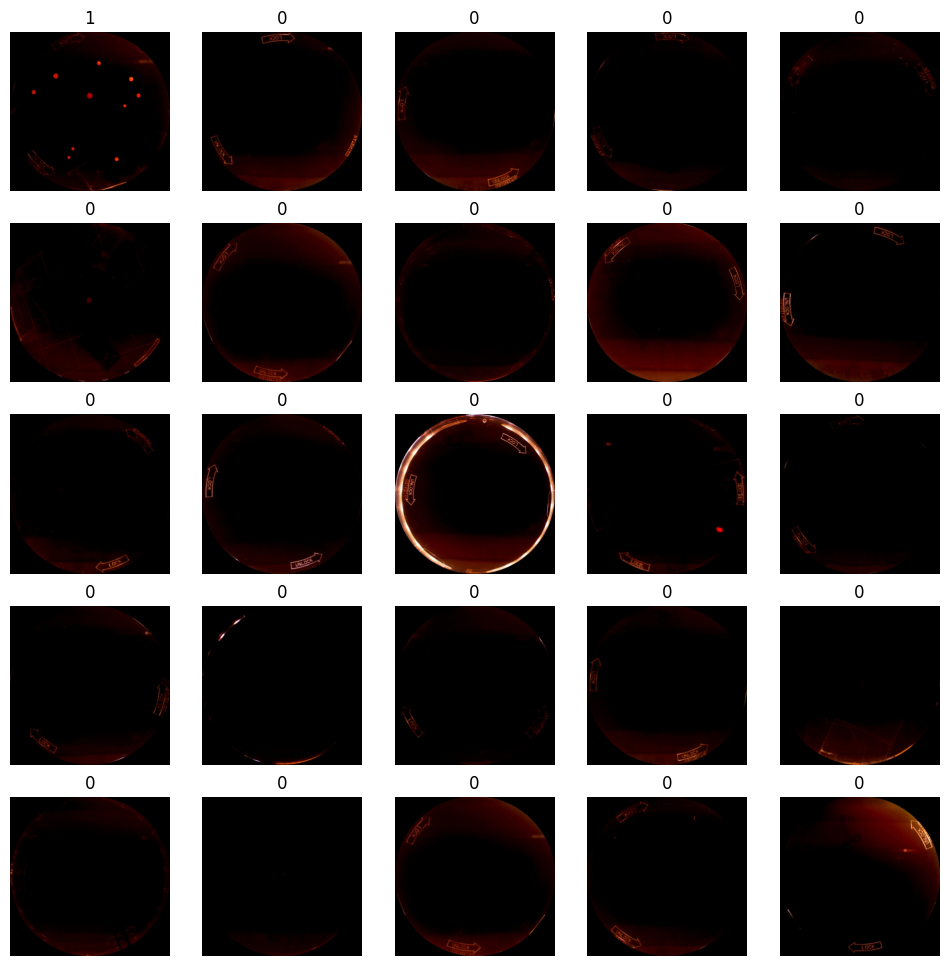

In [ ]:
# Visualize random 25 images to make sure it makes sense
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(5) for j in np.arange(5)]:
    idx = np.random.choice(np.arange(len(y)))
    file = os.path.join(input_dir, X_files[idx])
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    axs[i,j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i,j].set_title(y[idx])
    axs[i,j].axis('off')

plt.show()

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix, PrecisionRecallDisplay, precision_recall_curve
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

def prepare_files(X, y, test_size=TEST_SIZE, random_state=RAND_SEED):
    # On the highly imbalanced dataset I can not rely on the random split between training and val sets
    # Test subset can randomly have too few or too many positive cases
    # Have to select pre-defined number of random images from each class and stack them together
    np.random.seed(RAND_SEED) # For reproducibility

    #  Make two arrays with images: one for positive and one for negative images
    pos_im = [X[i] for i in range(X.shape[0]) if y[i]]
    pos_im = np.array(pos_im)
    neg_im = [X[i] for i in range(X.shape[0]) if not y[i]]
    neg_im = np.array(neg_im)
    num_pos = pos_im.shape[0]
    num_neg = neg_im.shape[0]
    print(f'Full dataset: {num_pos} images with bacteria and {num_neg} without')

    # Select random positive images
    # Make two random indeces for val and train
    idx_pos_val = np.random.choice(np.arange(num_pos), int(num_pos*TEST_SIZE), replace = False)
    idx_pos_train = [i for i in np.arange(num_pos) if i not in idx_pos_val]
    #  Apply this index to the array of image names
    X_val_pos = pos_im[idx_pos_val]
    X_train_pos = pos_im[idx_pos_train]
    y_val_pos = np.ones(len(idx_pos_val))
    y_train_pos = np.ones(len(idx_pos_train))

    # Select random negative images
    # Make two random indeces for val and train
    idx_neg_val = np.random.choice(np.arange(num_neg), int(num_neg*TEST_SIZE), replace = False)
    idx_neg_train = [i for i in np.arange(num_neg) if i not in idx_neg_val]

    #  Apply this index to the array of image names
    X_val_neg = neg_im[idx_neg_val]
    X_train_neg = neg_im[idx_neg_train]
    y_val_neg = np.zeros(len(idx_neg_val))
    y_train_neg = np.zeros(len(idx_neg_train))

    # Stack two classes together
    X_val = np.concatenate((X_val_neg, X_val_pos), axis = 0)
    y_val = np.concatenate((y_val_neg, y_val_pos), axis = 0)
    X_train = np.concatenate((X_train_neg, X_train_pos), axis = 0)
    y_train = np.concatenate((y_train_neg, y_train_pos), axis = 0)

    # Shuffle validation
    print("Suffling validation dataset ....")
    num_val = X_val.shape[0]
    indices = np.arange(num_val)
    shuffled_indices = np.random.permutation(indices)
    X_val = X_val[shuffled_indices]
    y_val = y_val[shuffled_indices]
    print(f"{X_val.shape} - {y_val.shape}")

    # Shuffle training
    print("Suffling trainig dataset ....")
    num_train = X_train.shape[0]
    indices = np.arange(num_train)
    shuffled_indices = np.random.permutation(indices)
    X_train = X_train[shuffled_indices]
    y_train = y_train[shuffled_indices]

    #Conver to np array and normalize
    y_train = np.array(y_train).astype(int)
    y_val = np.array(y_val).astype(int)

    # One-hot encode the labels
    num_classes = max(np.max(y_train), np.max(y_val)) + 1
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_val = to_categorical(y_val, num_classes=num_classes)

    print(f"Vlaidation X: {X_val.shape}; y: {y_val.shape}")
    print(f"Training X: {X_train.shape}; y: {y_train.shape}")

    return X_train, X_val, y_train, y_val

def read_images(files, file_dir):
  print(f"Reading {len(files)} images from {file_dir.split('/')[-1]}...", end = " ")
  X = []
  for file_name in files:
      file = os.path.join(file_dir, file_name)
      img = cv2.imread(file, cv2.IMREAD_COLOR)
      X.append(img)
  X = np.array(X)
  print("Done")
  return X

def read_aug_images(files, file_dir):
  print(f"Reading and agumenting {len(files)} images from {file_dir.split('/')[-1]}...", end = " ")
  # Get labels from filenames
  y = []
  for filename in files:
    num_colonies = int(filename.split('-')[2].strip().split('.')[0])
    if num_colonies == 0:
      y.append(0)
    else:
      y.append(1)

  # Sort file in to positive and negative
  pos_im_files = [files[i] for i in range(files.shape[0]) if y[i]]
  pos_im_files = np.array(pos_im_files)
  neg_im_files = [files[i] for i in range(files.shape[0]) if not y[i]]
  neg_im_files = np.array(neg_im_files)
  num_pos = pos_im_files.shape[0]
  num_neg = neg_im_files.shape[0]
  print(f'Before augmentation: {num_pos} images with bacteria and {num_neg} without')


  X = []
  y_new = []
  for lbl, file_name in zip(y, files):
      if lbl == 0:
        y_new.append(0)
        file_path = os.path.join(file_dir, file_name)
        img = cv2.imread(file_path, cv2.IMREAD_COLOR)
        X.append(img)
      else:
        file_path = os.path.join(file_dir, file_name)
        img = cv2.imread(file_path, cv2.IMREAD_COLOR)

        #Append image
        X.append(img)
        y_new.append(1)

        #Append flips
        img_flip_h = cv2.flip(img, 1)
        X.append(img_flip_h)
        y_new.append(1)
        img_flip_v = cv2.flip(img, 0)
        X.append(img_flip_v)
        y_new.append(1)

        #Append 10 superpositions of positive with random negatives
        try:
          #Get indecies of 20 random negative files
          neg_idx = np.random.choice(num_neg, 20, replace = False)
          for i, idx in enumerate(neg_idx):
              #Read the negative file
              neg_background_path= os.path.join(file_dir, neg_im_files[idx])
              neg_bckgr_im = cv2.imread(neg_background_path, cv2.IMREAD_COLOR)

              #Superimpose positive and negative
              new_im = np.maximum(img, neg_bckgr_im)

              #Append to teh ouput array
              X.append(new_im)
              y_new.append(1)
        except:
          print('Something went wrong')

  y_new = np.array(y_new).astype(int)
  X = np.array(X)

  # Shuffle resulting dataset
  print("Suffling dataset ....")
  num_im = X.shape[0]
  indices = np.arange(num_im)
  shuffled_indices = np.random.permutation(indices)
  X = X[shuffled_indices]
  y_new = y_new[shuffled_indices]
  print(f"Data set shape {X.shape}; labeles shape {y_new.shape}")

  num_pos = y_new.sum()
  num_neg = len(y_new) - y_new.sum()
  num_classes = 2

  y_new = to_categorical(y_new, num_classes=num_classes)

  print(f'After augmentation: {num_pos} images with bacteria and {num_neg} without')
  return X, y_new


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, PrecisionRecallDisplay

def evaluate_model(model,history, X_val, y_val, plot_target = False):
    # Evaluate the model
    y_true = np.argmax(y_val, axis=1)
    y_pred = model.predict(X_val)

    y_pred_dense = np.argmax(y_pred, axis=1)
    f1 = f1_score(y_true, y_pred_dense, average='weighted')
    accuracy = accuracy_score(y_true, y_pred_dense)
    recall = recall_score(y_true, y_pred_dense)

    # Convergence time
    convergence = history.history['loss'][-1]

    #Plot confusion matrics
    cm = confusion_matrix(y_true, y_pred_dense)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = [f'{value}' for value in cm.flatten()]
    group_percentages = [f'{value:.2f}' for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Reds')

    #Plot precision and recall
    display = PrecisionRecallDisplay.from_predictions(y_true, y_pred[:,1], name="CNN Model")
    _ = display.ax_.set_title("Precision-Recall curve")
    _ = display.ax_.set_xlim(0,1)
    _ = display.ax_.set_ylim(0,1)
    _ = display.ax_.spines['top'].set_visible(False)
    _ = display.ax_.spines['right'].set_visible(False)
    if plot_target:
      _ = display.ax_.fill_between([0.99,1], [0.3,0.3], [1,1], facecolor = 'green', alpha=.5)

    return f1, accuracy, convergence

def save_errors(model_dir, file_name, y_true, y_pred, thr=0.05, iteration = 0):
  y_pred_thr = [int(i > thr) for i in y_pred[:,1] ]
  errors = [i for i in range(len(y_true)) if (y_true[i]!=y_pred_thr[i]) ]
                            
  # Save errors
  file_path = os.path.join(model_dir, file_name)
  if os.path.exists(file_path):
      append_write = 'a+' # append if already exists
  else:
      append_write = 'w+' # make a new file if not
  with open(file_path, append_write) as file_err:
    csvwriter = csv.DictWriter(file_err, delimiter='\t', fieldnames=["iteration", "name", "true", "pred"])
    if iteration == 0 :
      csvwriter.writeheader()
    for idx in errors:
      csvwriter.writerow({"iteration":iteration, "name":X_val_names[idx], "true": y_true[idx] , "pred":y_pred_thr[idx]})

def save_hist(model_dir, file_name, history, iteration = 0, thresholded = 0):
  file_path = os.path.join(model_dir, file_name)
  if os.path.exists(file_path):
      append_write = 'a+' # append if already exists
  else:
      append_write = 'w+' # make a new file if not
  with open(file_path, append_write) as file_hist:
    csvwriter = csv.DictWriter(file_hist, delimiter='\t', fieldnames=["iteration", "thresholded?", "epoch", "train_loss", "train_acc", "val_loss", "val_acc"])
    if iteration == 0 :
      csvwriter.writeheader()
    for i in range(len(history.history['val_loss'])):
      csvwriter.writerow({"iteration":iteration, "thresholded?": thresholded, 
                          "epoch":i+1,
                          "train_loss":history.history['loss'][i],
                          "train_acc":history.history['accuracy'][i],
                          "val_loss":history.history['val_loss'][i],
                          "val_acc":history.history['val_accuracy'][i]})
      
def save_rep_rec(model_dir, file_name, iteration = 0, thresholded = 0):
  precision, recall, thresholds = precision_recall_curve(y_true, y_pred[:,1])

  file_path = os.path.join(model_dir, file_name)
  if os.path.exists(file_path):
      append_write = 'a+' # append if already exists
  else:
      append_write = 'w+' # make a new file if not
  with open(file_path, append_write) as file_prrec:
    csvwriter = csv.DictWriter(file_prrec, delimiter='\t', fieldnames=["iteration", "thresholded?", "threshold", "precision", "recall"])
    if iteration == 0 :
      csvwriter.writeheader()
    for thr, pr, rec in zip(thresholds, precision, recall):
      csvwriter.writerow({"iteration":iteration, "thresholded?": thresholded,
                          "threshold":thr,
                          "precision":pr,
                          "recall":rec})

In [ ]:
def build_model(num_classes):
    img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=1),
        #layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        #layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",)

    inputs = Input(shape=INPUT_SHAPE)
    x = img_augmentation(inputs)
    model = EfficientNetB5(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = BatchNormalization()(x)
    x = Dense(1024, activation="relu", name="NN1")(x)
    top_dropout_rate = 0.2
    x = Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

#Set up early stopping monitor
class CustomStopper(EarlyStopping):
    def __init__(self, monitor='val_loss',
             patience=10, verbose=0, mode='auto', start_epoch = 10, restore_best_weights=True): # add argument for starting epoch
        super(CustomStopper, self).__init__()
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch > self.start_epoch:
            super().on_epoch_end(epoch, logs)

early_stopping = CustomStopper()

In [ ]:
# Get the names of the files that will be used for both thresholded and non-thresholded images 
X_train_names, X_val_names, _ , y_val = prepare_files(X_files, y, test_size=TEST_SIZE, random_state=RAND_SEED)

# Read the actual files
print("Reading images...")
no_thr_dir = os.path.join(p, f'{SIZE}')   #Set the folder where nonthreholded files live 
X_train, y_train = read_aug_images(X_train_names, no_thr_dir)
X_val = read_images(X_val_names, no_thr_dir)

# Create a TensorFlow Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
#Define the model
model = build_model(2)

# Train the model with the early stopping callback
print("Training model...")
start_time = time.time()
history = model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data, verbose = 2, callbacks = [early_stopping])
end_time = time.time()
print(f"Training took {end_time - start_time:.2f} seconds")

Full dataset: 300 images with bacteria and 3479 without
Suffling validation dataset ....
(1133,) - (1133,)
Suffling trainig dataset ....
Vlaidation X: (1133,); y: (1133, 2)
Training X: (2646,); y: (2646, 2)
Reading images...
Reading and agumenting 2646 images from 456... Before augmentation: 210 images with bacteria and 2436 without
After augmentation: 4830 images with bacteria and 2436 without
Reading 1133 images from 456... Done


115263384/115263384 [==============================] - 5s 0us/step
Training model...
Epoch 1/100
228/228 - 238s - loss: 0.8671 - accuracy: 0.8420 - val_loss: 0.4749 - val_accuracy: 0.7758 - 238s/epoch - 1s/step
Epoch 2/100
228/228 - 212s - loss: 0.3126 - accuracy: 0.8958 - val_loss: 0.1764 - val_accuracy: 0.9320 - 212s/epoch - 928ms/step
Epoch 3/100
228/228 - 211s - loss: 0.2006 - accuracy: 0.9268 - val_loss: 0.1998 - val_accuracy: 0.9232 - 211s/epoch - 927ms/step
Epoch 4/100
228/228 - 212s - loss: 0.1740 - accuracy: 0.9352 - val_loss: 0.2345 - val_accuracy: 0.9126 - 212s/epoch - 929ms/step
Epoch 5/100
228/228 - 212s - loss: 0.1350 - accuracy: 0.9531 - val_loss: 0.2356 - val_accuracy: 0.9223 - 212s/epoch - 928ms/step
Epoch 6/100
228/228 - 212s - loss: 0.1342 - accuracy: 0.9540 - val_loss: 0.4000 - val_accuracy: 0.8941 - 212s/epoch - 928ms/step
Epoch 7/100
228/228 - 212s - loss: 0.1308 - accuracy: 0.9549 - val_loss: 0.2172 - val_accuracy: 0.9356 - 212s/epoch - 929ms/step
Epoch 8/100
228

In [ ]:
iteration = 0
# Save results and telemetry into a csv
print("Saving data...")
y_true = np.argmax(y_val, axis=1)
y_pred = model.predict(X_val)
p = os.path.abspath('.')
model.save(model_dir)
model_dir = os.path.join(p, "drive", "MyDrive", 'EffNet', 'B5')
np.savetxt(model_dir+f"/{iteration}B5y_pred_custom_aug_before_tune.csv", y_pred, delimiter="\t")
np.savetxt(model_dir+f"/{iteration}B5y_true_custom_aug_before_tune.csv", y_true, delimiter="\t")
save_errors(model_dir, 'B5_errors_custom_aug_before_tune.csv', y_true, y_pred, 0.001, iteration)
save_rep_rec(model_dir, 'B5_prec_rec_custom_aug_before_tune.csv', iteration = iteration)
save_hist(model_dir, 'B5_hist_custom_aug_before_tune.csv', history, iteration = iteration)

Saving data...
36/36 [==============================] - 31s 790ms/step


In [ ]:
unfreeze_model(model)
history1 = model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data, verbose = 2, callbacks = [early_stopping])

Epoch 1/100
228/228 - 243s - loss: 0.0768 - accuracy: 0.9729 - val_loss: 0.2302 - val_accuracy: 0.9629 - 243s/epoch - 1s/step
Epoch 2/100
228/228 - 224s - loss: 0.0577 - accuracy: 0.9809 - val_loss: 0.1652 - val_accuracy: 0.9647 - 224s/epoch - 982ms/step
Epoch 3/100
228/228 - 224s - loss: 0.0382 - accuracy: 0.9865 - val_loss: 0.1733 - val_accuracy: 0.9691 - 224s/epoch - 982ms/step
Epoch 4/100
228/228 - 224s - loss: 0.0313 - accuracy: 0.9893 - val_loss: 0.1517 - val_accuracy: 0.9691 - 224s/epoch - 983ms/step
Epoch 5/100
228/228 - 224s - loss: 0.0251 - accuracy: 0.9911 - val_loss: 0.1530 - val_accuracy: 0.9718 - 224s/epoch - 982ms/step
Epoch 6/100
228/228 - 224s - loss: 0.0167 - accuracy: 0.9946 - val_loss: 0.1394 - val_accuracy: 0.9709 - 224s/epoch - 982ms/step
Epoch 7/100
228/228 - 224s - loss: 0.0231 - accuracy: 0.9933 - val_loss: 0.1313 - val_accuracy: 0.9700 - 224s/epoch - 983ms/step
Epoch 8/100
228/228 - 224s - loss: 0.0209 - accuracy: 0.9920 - val_loss: 0.1247 - val_accuracy: 0.96

In [ ]:
# Save results and telemetry into a csv
print("Saving data...")
y_true = np.argmax(y_val, axis=1)
y_pred = model.predict(X_val)
p = os.path.abspath('.')
model.save(model_dir)
model_dir = os.path.join(p, "drive", "MyDrive", 'EffNet', 'B5')
np.savetxt(model_dir+f"/{iteration}B5y_pred_custom_aug_tuned.csv", y_pred, delimiter="\t")
np.savetxt(model_dir+f"/{iteration}B5y_true_custom_aug_tuned.csv", y_true, delimiter="\t")
save_errors(model_dir, 'B5_errors_custom_aug_tuned.csv', y_true, y_pred, 0.001, iteration)
save_rep_rec(model_dir, 'B5_prec_rec_custom_aug_tuned.csv', iteration = iteration)
save_hist(model_dir, 'B5_hist_custom_aug_tuned.csv', history1, iteration = iteration)

Saving data...
36/36 [==============================] - 26s 747ms/step


36/36 [==============================] - 26s 749ms/step


(0.9677236854226243, 0.9682259488084731, 0.018068745732307434)

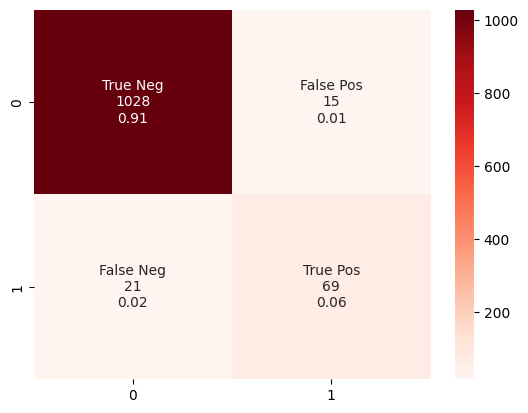

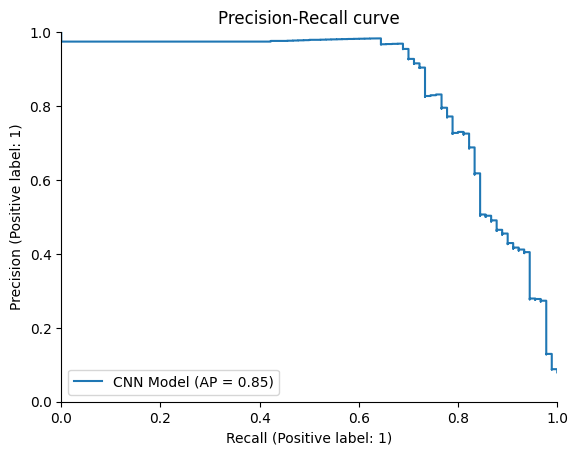

In [ ]:
evaluate_model(model,history1, X_val, y_val, plot_target = False)